# Testing grounds

## Setup

### Imports

In [1]:
import os
import numpy as np
from main import load_agent_model, train
import gymnasium as gym
from gymnasium.wrappers.flatten_observation import FlattenObservation
from footsies_gym.envs.footsies import FootsiesEnv
from footsies_gym.wrappers.normalization import FootsiesNormalized
from footsies_gym.wrappers.action_comb_disc import FootsiesActionCombinationsDiscretized
from footsies_gym.wrappers.statistics import FootsiesStatistics
from footsies_gym.wrappers.frame_skip import FootsiesFrameSkipped
from importlib import reload
import pprint

pp = pprint.PrettyPrinter(indent=4)

### Environment

#### Footsies

In [2]:
human_testing_kwargs = {
    "fast_forward": False,
    "vs_player": True,
}

normal_testing_kwargs = {
    "frame_delay": 0,
    "dense_reward": True,
}

different_addresses_kwargs = {
    "game_port": 14000,
    "opponent_port": 14001,
}

In [3]:
footsies_env = FootsiesEnv(
    game_path="../Footsies-Gym/Build/FOOTSIES.x86_64",
    **normal_testing_kwargs,
    # **human_testing_kwargs,
    **different_addresses_kwargs,
    render_mode="human",
    log_file=os.path.join(os.getcwd(), "out.log"),
    log_file_overwrite=True,
)

statistics = FootsiesStatistics(footsies_env)

FRAME_SKIP = True

env = FootsiesActionCombinationsDiscretized(
    FlattenObservation(
        FootsiesNormalized(statistics)
        if not FRAME_SKIP
        else FootsiesFrameSkipped(FootsiesNormalized(statistics))
    )
)

#### CartPole

In [3]:
env = gym.make("CartPole-v1")

## Environment testing

In [4]:
def report_env(obs, info, reward = None, terminated = None, truncated = None):
    print("Observation:")
    pp.pprint(obs)

    if reward is not None or terminated is not None or truncated is not None:
        print()
    if reward is not None:
        print("Reward:", reward)
    if terminated is not None:
        print("Terminated:", terminated)
    if truncated is not None:
        print("Truncated:", truncated)

    print()
    print("Info:")
    pp.pprint(info)

In [66]:
obs, info = env.reset()
report_env(obs, info)

{'guard': [1.0, 1.0], 'move': [0, 0], 'move_frame': [0.0, 0.0], 'position': [-0.45454545454545453, 0.45454545454545453]}
Observation:
array([ 1.        ,  1.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.45454547,  0.45454547])
None

Info:
{   'frame': 0,
    'p1_action': (False, False, False),
    'p2_action': (False, False, False)}
None


In [176]:
obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
report_env(obs, info, reward, terminated, truncated)

{'guard': [0.0, 0.0], 'move': [0, 1], 'move_frame': [0.0, 0.0], 'position': [-0.8381816473874178, 0.24909024888818912]}
Observation:
array([ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.83818167,  0.24909025])
None

Reward: 0.0
Terminated: False
Truncated: False

Info:
{   'frame': 1002,
    'p1_action': (False, False, False),
    'p2_action': (True, False, False)}
None


In [9]:
for e in range(5):
    print("Env reset")
    obs, info = env.reset()
    terminated, truncated = False, False

    while not (terminated or truncated):
        obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
        if reward != 0.0:
            print(reward)

Env reset
0.3
0.7
Env reset
0.3
0.7
Env reset
0.3
0.7
Env reset
0.3
0.7
Env reset
0.3
0.7


## Brisket testing

### Create agent

In [5]:
import torch
from agents.brisket.agent import FootsiesAgent as BrisketAgent
from agents.brisket.loggables import get_loggables as get_brisket_loggables
from agents.logger import TrainingLoggerWrapper

For reloading in case changes were made

In [21]:
import agents.brisket.agent
import agents.logger
import agents.base
reload(agents.brisket.agent)
reload(agents.logger)
reload(agents.base)

<module 'agents.base' from '/home/martinho/projects/footsies-agents/agents/base.py'>

In [6]:
brisket = {
    "Footsies": lambda: BrisketAgent(
        observation_space=env.observation_space,
        action_space=env.action_space,
        
        # For testing
        epsilon=0,
        epsilon_decay_rate=0,
        min_epsilon=0,
    ),
    "CartPole": lambda: BrisketAgent(
        observation_space=env.observation_space,
        action_space=env.action_space,

        shallow=True,
        shallow_size=4,
        epsilon_decay_rate=0.001,
    )
}["Footsies"]()

In [29]:
brisket = TrainingLoggerWrapper(
    brisket,
    float("+inf"),  # never log
    cummulative_reward=False,
    win_rate=False,
    test_states_number=5000,
    **get_brisket_loggables(brisket),
)

In [7]:
load_agent_model(brisket, "brisket_frameskipped")

Agent loaded


### Test output of a single state

In [39]:
experience = np.array([t[0] for t in brisket.test_states])

In [44]:
(experience[:, 0] != 1.0).sum()

1018

In [74]:
from footsies_gym.utils import get_dict_obs_from_vector_obs
from footsies_gym.wrappers.normalization import FootsiesNormalized

In [80]:
import footsies_gym.wrappers.normalization
import footsies_gym.utils

In [79]:
reload(footsies_gym.utils)
reload(footsies_gym.wrappers.normalization)

<module 'footsies_gym.wrappers.normalization' from '/home/martinho/projects/Footsies-Gym/footsies-gym/footsies_gym/wrappers/normalization.py'>

In [77]:
FootsiesNormalized = footsies_gym.wrappers.normalization.FootsiesNormalized

In [81]:
footsies_gym.utils.get_dict_obs_from_vector_obs(e, normalized=True, flattened=True)

{'guard': [3.0, 3.0],
 'move': [0, 0],
 'move_frame': [0.0, 0.0],
 'position': [-2.0000000596046448, 2.0000000596046448]}

In [47]:
e = experience[0, :]

In [60]:
np.argwhere(e[17:17+15] == 1.0).item()

0

In [64]:
e[34]

-0.4545454680919647

In [50]:
list(e[2:])

[1.0, 1.0]

### Training

In [8]:
train(brisket, env, 1000)

Preprocessing... done!


100%|██████████| 1000/1000 [05:17<00:00,  3.15it/s]


In [9]:
env.close()

In [10]:
print(sum(statistics.metric_special_moves_per_episode))
print(sum(statistics.metric_special_moves_from_neutral_per_episode))

882
0


In [44]:
prev_obs = None
obs, info = env.reset()
report_env(obs, info)

Observation:
array([ 0.03174489, -0.02254564, -0.01391198,  0.02921619], dtype=float32)

Info:
{}


In [45]:
action = brisket.act(obs)
"Left" if action == 0 else "Right"

'Right'

In [47]:
prev_obs = obs
obs, reward, truncated, terminated, info = env.step(action)
report_env(obs, info, reward, truncated, terminated)

Observation:
array([ 0.03474943,  0.3680826 , -0.01868412, -0.56468004], dtype=float32)

Reward: 1.0
Terminated: False
Truncated: False

Info:
{}


In [50]:
brisket.q_values(brisket._obs_to_torch(obs))

[-0.47500109672546387, -0.2977886199951172]

### Statistics

In [15]:
print("Number of special moves:", sum(statistics.metric_special_moves_per_episode))

264

### Self-play test

In [8]:
pi = brisket.extract_policy(env)

In [11]:
footsies_env.set_opponent(pi)

False

In [12]:
train(brisket, env, 10)

Preprocessing... done!


  0%|          | 0/10 [00:16<?, ?it/s]

Game closed manually, quitting training


## Importance sampling test

In [1]:
import numpy as np
import pandas as pd
import random

In [2]:
np.set_printoptions(precision=2)

In [3]:
# rock, paper, scissors
def uniform_random_play_vec(r):
    r[:] = np.floor(r * 3)

def rocky_play_vec(r):
    r[r < 0.8] = 0
    r[(r < 0.9) & (r >= 0.8)] = 1
    r[(r < 1.0) & (r >= 0.9)] = 2

def scissors_play_vec(r):
    r[r < 0.9] = 2
    r[(r < 0.95) & (r >= 0.9)] = 1
    r[(r < 1.0) & (r >= 0.95)] = 0

In [4]:
# rock, paper, scissors
uniform_random_play = lambda: random.randint(0, 2)
rocky_play = lambda: 0 if random.random() < 0.8 else random.randint(1, 2)
scissors_play = lambda: 2 if random.random() < 0.9 else random.randint(0, 1)

In [5]:
# rock, paper, scissors
uniform_random_play_table = np.array([1/3, 1/3, 1/3])
rocky_play_table = np.array([0.8, 0.1, 0.1])
scissors_play_table = np.array([0.05, 0.05, 0.9])

The opponent is not part of the state to emulate *unreactablability*.

**TODO**: maybe try, at maximum, using the previous state as the state, as it's uncorrelated anyway?

In [6]:
def rps(p1, p2):
    offset = 1 - p1
    reward = ((p1 + offset) % 3) - ((p2 + offset) % 3)
    return reward


# state is binary: 00 start, 01 p1 won first, 10 p2 won second, 11 match point
def rps_episodic(p1, p2, state):
    reward = rps(p1, p2)
    p1_won = reward > 0
    tie = reward == 0

    if state == 0:
        return 0, (1 if p1_won else 3 if tie else 2)

    if state == 1:
        if p1_won:
            return reward, 4
        
        return 0, 3
    
    if state == 2:
        if p1_won or tie:
            return 0, 3

        return reward, 4

    if state == 3:
        return reward, 4

    return None


# is_fix -> importance sampling fix
def calculate_q_function_td(player, opponent, N: int = int(1e6), lr: float = 0.1, discount: float = 0.0, is_fix: bool = False, is_table = None, episodic: bool = False):
    # S x A
    q = np.zeros((1, 3)) if not episodic else np.zeros((4, 3))

    for _ in range(N):
        if episodic:
            state = 0
            terminated = False
            while not terminated:
                ours = player()
                theirs = opponent()    

                reward, next_state = rps_episodic(ours, theirs, state)
                terminated = next_state == 4

                modifier = 1 / (3 * is_table[theirs]) if is_fix else 1
                if not terminated:
                    q[state, ours] = q[state, ours] + lr * (modifier * (reward + discount * q[next_state, ours]) - q[state, ours])
                else:
                    q[state, ours] = q[state, ours] + lr * (modifier * reward - q[state, ours])

                state = next_state

        else:
            ours = player()
            theirs = opponent()

            reward = rps(ours, theirs)
            modifier = 1 / (3 * is_table[theirs]) if is_fix else 1

            q[0, ours] = q[0, ours] + lr * (modifier * reward + discount * q[0, ours] - q[0, ours])
        
    return q


# here N is timesteps, not episodes
def calculate_q_function_mc(player, opponent, N: int = int(1e6), is_fix: bool = False, is_table = None, episodic: bool = False):
    rand = np.random.random((N, 2))
    player(rand[:, 0])
    opponent(rand[:, 1])

    p1 = rand[:, 0].astype(np.int8)
    p2 = rand[:, 1].astype(np.int8)

    reward = rps(p1, p2)

    df = pd.DataFrame(np.array([p1, reward]).T, columns=["a", "r"])

    if is_fix:
        df["r"] = df["r"] / (3 * is_table[p2[:-1]])

    return df.groupby("a").mean()

In [140]:
def rps_episodic_pandas(df, step: int):
    N = df.shape[0]
    ixer = np.arange(N // 5) * 5 + step

    print("a")

    rps_results = rps(df.iloc[ixer]["p1"], df.iloc[ixer]["p2"])

    print("b")

    p1_won = rps_results > 0
    tie = rps_results == 0
    p2_won = rps_results < 0

    print("c")

    p1_won.index = rps_results.index + 1
    tie.index = rps_results.index + 1
    p2_won.index = rps_results.index + 1

    print("d")

    p1_won = p1_won.reindex(index=df.index, fill_value=False)
    tie = tie.reindex(index=df.index, fill_value=False)
    p2_won = p2_won.reindex(index=df.index, fill_value=False)

    print("e")

    state = df.iloc[ixer]["state"]
    state.index = state.index + 1
    state.reindex(index=df.index, fill_value=False)

    print("f")

    # eww
    df.loc[p1_won & (state == 0), ("state", "reward")] = 1, 0
    print("0", end="")
    df.loc[p1_won & (state == 1), ("state", "reward")] = 4, 1
    print("0", end="")
    df.loc[p1_won & (state == 2), ("state", "reward")] = 3, 0
    print("0", end="")
    df.loc[p1_won & (state == 3), ("state", "reward")] = 4, 1
    print("0", end="")
    df.loc[tie    & (state == 0), ("state", "reward")] = 3, 0
    print("0", end="")
    df.loc[tie    & (state == 1), ("state", "reward")] = 3, 0
    print("0", end="")
    df.loc[tie    & (state == 2), ("state", "reward")] = 3, 0
    print("0", end="")
    df.loc[tie    & (state == 3), ("state", "reward")] = 4, 0
    print("0", end="")
    df.loc[p2_won & (state == 0), ("state", "reward")] = 2, 0
    print("0", end="")
    df.loc[p2_won & (state == 1), ("state", "reward")] = 3, 0
    print("0", end="")
    df.loc[p2_won & (state == 2), ("state", "reward")] = 4, -1
    print("0", end="")
    df.loc[p2_won & (state == 3), ("state", "reward")] = 4, -1
    print("0", end="")

In [21]:
calculate_q_function_td(uniform_random_play, scissors_play, N=int(1e5), lr=1e-3, discount=0.0)

array([[ 0.86, -0.85, -0.01]])

In [9]:
calculate_q_function_mc(uniform_random_play_vec, scissors_play_vec, N=int(1e7))

,r
a,
0,0.850117
1,-0.850102
2,-0.000105


In [37]:
calculate_q_function_td(uniform_random_play, scissors_play, N=int(1e5), lr=1e-3, discount=0.0, is_fix=True, is_table=scissors_play_table)

array([[-0.04,  0.06,  0.01]])

In [38]:
calculate_q_function_mc(uniform_random_play_vec, scissors_play_vec, N=int(1e7), is_fix=True, is_table=scissors_play_table)

,r
a,
0,-0.000709
1,0.000795
2,-0.000647


In [7]:
calculate_q_function_td(uniform_random_play, uniform_random_play, N=int(1e5), lr=1e-3, discount=1.0, episodic=True, is_fix=False, is_table=uniform_random_play_table)

array([[ 0.01, -0.01,  0.01],
       [ 0.35,  0.31,  0.37],
       [-0.32, -0.34, -0.33],
       [ 0.02, -0.01,  0.  ]])

In [25]:
calculate_q_function_td(uniform_random_play, scissors_play, N=int(1e5), lr=1e-3, discount=1.0, episodic=True, is_fix=False, is_table=scissors_play_table)

array([[ 0.97, -0.97, -0.01],
       [ 0.99, -0.75,  0.05],
       [ 0.75, -0.99, -0.06],
       [ 0.86, -0.85, -0.01]])

In [7]:
fixed = calculate_q_function_td(uniform_random_play, scissors_play, N=int(1e5), lr=1e-3, discount=1.0, episodic=True, is_fix=True, is_table=scissors_play_table)
fixed

array([[ 0.01, -0.02, -0.02],
       [ 0.34,  0.37,  0.26],
       [-0.34, -0.34, -0.35],
       [-0.01, -0.03, -0.05]])

In [9]:
scissors_play_table

array([0.05, 0.05, 0.9 ])

In [15]:
# Q(0, rock) if assuming scissors player?
# Q(0, rock) = P(0 -> 1, rock) max(Q(1, rock) + Q(1, paper) + Q(1, scissors)) + P(0 -> 2, rock) max(Q(2, rock) + Q(2, paper) + Q(2, scissors)) + P(0 -> 3, rock) max(Q(3, rock) + Q(3, paper) + Q(3, scissors))
#            = 0.9 * Q(1, .) + 0.05 * Q(2, .) + 0.05 * Q(3, .)
# print("Q(0, rock):", np.sum(np.array([0.9, 0.05, 0.05]) * fixed.sum(axis=1)[1:]))
print("Q(0, rock):", np.sum(np.array([0.9, 0.05, 0.05]) * fixed.max(axis=1)[1:]))

# Q(0, paper) if assuming scissors player?
# Q(0, paper) = P(0 -> 1, paper) max(Q(1, rock) + Q(1, paper) + Q(1, scissors)) + P(0 -> 2, paper) max(Q(2, rock) + Q(2, paper) + Q(2, scissors)) + P(0 -> 3, paper) max(Q(3, rock) + Q(3, paper) + Q(3, scissors))
#            = 0.05 * Q(1, .) + 0.9 * Q(2, .) + 0.05 * Q(3, .)
print("Q(0, paper):", np.sum(np.array([0.05, 0.9, 0.05]) * fixed.max(axis=1)[1:]))

# Q(0, scissors) if assuming scissors player?
# Q(0, scissors) = P(0 -> 1, scissors) max(Q(1, rock) + Q(1, paper) + Q(1, scissors)) + P(0 -> 2, scissors) max(Q(2, rock) + Q(2, paper) + Q(2, scissors)) + P(0 -> 3, scissors) max(Q(3, rock) + Q(3, paper) + Q(3, scissors))
#            = 0.05 * Q(1, .) + 0.05 * Q(2, .) + 0.9 * Q(3, .)
print("Q(0, scissors):", np.sum(np.array([0.05, 0.05, 0.9]) * fixed.max(axis=1)[1:]))

Q(0, rock): 0.31911791423709474
Q(0, paper): -0.2836083944551429
Q(0, scissors): -0.00605036003947255


In [ ]:
# Through dynamic programming
def corrected_q_values(fixed_q_table, ):

## Toy experiments

### Actor-critic

In [1]:
from importlib import reload
import agents.a2c.a2c as a2c

In [2]:
reload(a2c)
ActorNetwork = a2c.ActorNetwork
CriticNetwork = a2c.CriticNetwork
A2CModule = a2c.A2CModule

In [3]:
import gymnasium
from gymnasium.wrappers.flatten_observation import FlattenObservation

In [4]:
env = FlattenObservation(
    gymnasium.make(
        "FrozenLake-v1",
        is_slippery=False,
        render_mode=None,
    )
)

action_labels = ["Move left", "Move down", "Move right", "Move up"]

In [6]:
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

obs_dim, action_dim

(16, 4)

In [8]:
import numpy as np
import torch
from torch import nn

In [9]:
model = A2CModule(
    actor=ActorNetwork(
        obs_dim=obs_dim,
        action_dim=action_dim,
        hidden_layer_sizes=[],
        hidden_layer_activation=nn.Identity,
    ),
    critic=CriticNetwork(
        obs_dim=obs_dim,
        hidden_layer_sizes=[],
        hidden_layer_activation=nn.Identity,
    ),
    discount=0.99,
    actor_learning_rate=1e-2,
    critic_learning_rate=1e-2,
)

In [55]:
obs, info = env.reset()

print("Observation:", obs)
print("Info:", info)

Observation: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Info: {'prob': 1}


In [47]:
action = model.act(obs)
action_labels[action]

'Move down'

In [48]:
next_obs, reward, terminated, truncated, info = env.step(action)

print("Next observation:", next_obs)
print("Reward:", reward)
print("Terminated:", terminated)
print("Truncated:", truncated)
print("Info", info)

Next observation: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Reward: 0.0
Terminated: False
Truncated: False
Info {'prob': 0.3333333333333333}


In [46]:
model.update(obs, next_obs, reward, terminated)
obs = next_obs

In [95]:
terminated, truncated = True, True

In [89]:
from IPython.display import clear_output

In [96]:
while True:
    while not (terminated or truncated):
        action = model.act(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        model.update(obs, next_obs, reward, terminated)
        obs = next_obs

    obs, info = env.reset()
    terminated, truncated = False, False

    clear_output(wait=True)
    print(model.value(torch.eye(16)).reshape(4, 4))

tensor([[-1.0658e+08, -5.3397e+07, -5.2142e+07, -5.2772e+07],
        [-3.5489e+07, -5.2408e+07, -5.4007e+07, -5.2408e+07],
        [-6.0602e+07, -5.2944e+07, -5.3168e+07, -5.2408e+07],
        [-5.2408e+07, -5.4675e+07, -5.3120e+07, -5.2408e+07]])


KeyboardInterrupt: 

In [91]:
env.close()

ModuleNotFoundError: No module named 'seaborn'

In [16]:
model.policy(torch.eye(16))

tensor([[0.2166, 0.2007, 0.3215, 0.2612],
        [0.2304, 0.2006, 0.3252, 0.2438],
        [0.2533, 0.2103, 0.3196, 0.2168],
        [0.2486, 0.2776, 0.2722, 0.2015],
        [0.2018, 0.2652, 0.2348, 0.2982],
        [0.1976, 0.2591, 0.3411, 0.2022],
        [0.2462, 0.2820, 0.2560, 0.2158],
        [0.2570, 0.1995, 0.3111, 0.2323],
        [0.2260, 0.1888, 0.3169, 0.2683],
        [0.2758, 0.2630, 0.2732, 0.1880],
        [0.2658, 0.1991, 0.3117, 0.2234],
        [0.2246, 0.2422, 0.3198, 0.2135],
        [0.2190, 0.2011, 0.3239, 0.2561],
        [0.2487, 0.2158, 0.3165, 0.2191],
        [0.2400, 0.2399, 0.2362, 0.2840],
        [0.2412, 0.2137, 0.2955, 0.2497]])

In [22]:
model.policy(torch.eye(16)).reshape(4, 4, 4)

tensor([[[0.2166, 0.2007, 0.3215, 0.2612],
         [0.2304, 0.2006, 0.3252, 0.2438],
         [0.2533, 0.2103, 0.3196, 0.2168],
         [0.2486, 0.2776, 0.2722, 0.2015]],

        [[0.2018, 0.2652, 0.2348, 0.2982],
         [0.1976, 0.2591, 0.3411, 0.2022],
         [0.2462, 0.2820, 0.2560, 0.2158],
         [0.2570, 0.1995, 0.3111, 0.2323]],

        [[0.2260, 0.1888, 0.3169, 0.2683],
         [0.2758, 0.2630, 0.2732, 0.1880],
         [0.2658, 0.1991, 0.3117, 0.2234],
         [0.2246, 0.2422, 0.3198, 0.2135]],

        [[0.2190, 0.2011, 0.3239, 0.2561],
         [0.2487, 0.2158, 0.3165, 0.2191],
         [0.2400, 0.2399, 0.2362, 0.2840],
         [0.2412, 0.2137, 0.2955, 0.2497]]])

In [ ]:
def policy_directions_map(model: A2CModule):
    directions_base = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    
    probs = model.policy(torch.eye(16)).reshape(4, 4, 4)

    return weight, directions

## RPS

In [1]:
import rps.rps as rps
import random

In [2]:
from importlib import reload
reload(rps)

<module 'rps.rps' from '/home/martinho/projects/footsies-agents/rps/rps.py'>

### Instantiate game

In [3]:
opponent_pool = {
    "uniform_random_play": lambda o, i: random.randint(0, 2),
    "rocky_play": lambda o, i: 0 if random.random() < 0.8 else random.randint(1, 2),
    "scissors_play": lambda o, i: 2 if random.random() < 0.9 else random.randint(0, 1),
    "imitator": lambda o, i: i["p1_action"] if i["step"] > 0 else random.randint(0, 2),
}

In [4]:
game = rps.RPS(
    opponent=opponent_pool["imitator"],
    dense_reward=False,
    health=3,
    flattened=True,
    observation_include_play=False,
    observation_transformer=lambda o: o.to(torch.float32).unsqueeze(0),
)

### Create agent

In [5]:
import torch
from agents.a2c.a2c import A2CModule, ActorNetwork, CriticNetwork
from torch import nn

In [43]:
from dataclasses import dataclass
from typing import Callable, Iterable

@dataclass
class ObservationModifier:
    dim:        int
    method:     Callable[[rps.RPSObservation, dict], rps.RPSObservation]
    universe:   Callable[[list[rps.RPSObservation]], Iterable[rps.RPSObservation]]

observation_neutral = ObservationModifier(
    game.observation_dim,
    lambda o, i: o,
    lambda os: iter(os),
)

def append_opponent_model_imitator_universe(os: list[rps.RPSObservation]) -> Iterable[rps.RPSObservation]:
    for o in os:
        for action in range(game.action_dim):
            yield torch.hstack((o, torch.nn.functional.one_hot(torch.tensor([action]), num_classes=3)))

observation_append_opponent_model_imitator = ObservationModifier(
    game.observation_dim + 3,
    lambda o, i: torch.hstack((o, torch.nn.functional.one_hot(torch.tensor([opponent_pool["imitator"](o, i)]), num_classes=3))),
    append_opponent_model_imitator_universe,
)

OBSERVATION_MODIFIER = observation_append_opponent_model_imitator
OBSERVATION_MODIFIER = observation_neutral

In [45]:
agent = A2CModule(
    actor=ActorNetwork(
        obs_dim=OBSERVATION_MODIFIER.dim,
        action_dim=game.action_dim,
        hidden_layer_sizes=[],
        hidden_layer_activation=nn.Identity,
    ),
    critic=CriticNetwork(
        obs_dim=OBSERVATION_MODIFIER.dim,
        hidden_layer_sizes=[],
        hidden_layer_activation=nn.Identity,
    ),
    actor_learning_rate=1e-2,
    critic_learning_rate=1e-2,
    actor_eligibility_traces_decay=0.0,
    critic_eligibility_traces_decay=0.0,
    optimizer=torch.optim.SGD,
)

### Game loop

In [57]:
obs, info = game.reset()
obs = OBSERVATION_MODIFIER.method(obs, info)
obs, info

(tensor([[0., 0., 1., 0., 0., 1., 1., 0., 0.]]),
 {'p1_health': 3,
  'p2_health': 3,
  'p1_play': 0,
  'p2_play': 0,
  'p1_action': 0,
  'p2_action': 0,
  'step': 0})

In [70]:
next_obs, reward, terminated, truncated, info = game.step(agent.act(obs))
next_obs = OBSERVATION_MODIFIER.method(next_obs, info) if next_obs is not None else obs
print("Next observation:", next_obs)
print("Reward:", reward)
print("Terminated:", terminated)
print("Truncated:", truncated)
print("Info:", info)

Next observation: tensor([[0., 0., 1., 1., 0., 0., 1., 0., 0.]])
Reward: 1.0
Terminated: True
Truncated: False
Info: {'p1_health': 2, 'p2_health': -3, 'p1_play': 0, 'p2_play': 1, 'p1_action': 0, 'p2_action': 1, 'step': 7}


In [42]:
agent.update(obs, next_obs, reward, terminated)

In [69]:
obs = next_obs

Train in a loop

In [9]:
import tqdm
from itertools import count, starmap

In [29]:
def print_results(include_plays: bool = False):
    healths_list = [(h1 + 1, h2 + 1) for h1 in range(game.health) for h2 in range(game.health)]
    plays_list = [(pl1, pl2) for pl1 in range(game.play_dim) for pl2 in range(game.play_dim)] if include_plays else [[None, None]]

    observations = starmap(game.craft_observation, sorted({
        tuple((*healths, *plays))
        for healths in healths_list
        for plays in plays_list
    }))

    # Modify and add more observations according to the current observation modifier
    observations = list(OBSERVATION_MODIFIER.universe(observations))

    results = {
        observation: (
            agent.value(observation).item(),
            agent.policy(observation).squeeze(),
        )
        for observation in observations
    }

    print("Value function:")
    for obs, (value, _) in results.items():
        print(f"{obs}: {value:.2f}")

    print()

    print("Policy:")
    for obs, (_, distribution) in results.items():
        print(f"{obs}: {distribution}")

In [24]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

print_every = 200
deltas = []
try:
    for i in tqdm.tqdm(count(), disable=True):
        obs, info = game.reset()
        obs = OBSERVATION_MODIFIER.method(obs, info)
        terminated, truncated = False, False

        while not (terminated or truncated):
            action = agent.act(obs)
            next_obs, reward, terminated, truncated, info = game.step(action)
            next_obs = OBSERVATION_MODIFIER.method(next_obs, info) if next_obs is not None else obs
            agent.update(obs, next_obs, reward, terminated)
            obs = next_obs

        # if i % print_every == 0:
        #     clear_output(wait=True)
        #     print_results(include_plays=False)
        #     print()
            print(i, end="\r")
            # print(agent.delta, end="\r")
        
        deltas.append(agent.delta)
            
except KeyboardInterrupt:
    pass

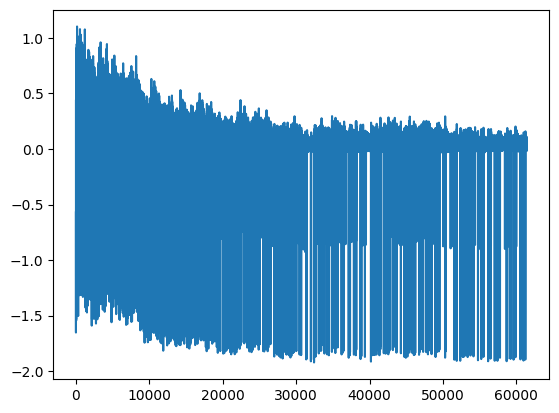

In [25]:
plt.plot(deltas)

### Evaluation

In [32]:
torch.set_printoptions(precision=2, sci_mode=False)

In [33]:
print_results(include_plays=False)

Value function:
tensor([[1., 0., 0., 1., 0., 0., 0.]]): 0.90
tensor([[1., 0., 0., 1., 0., 0., 1.]]): 0.90
tensor([[1., 0., 0., 1., 0., 0., 2.]]): 0.90
tensor([[1., 0., 0., 0., 1., 0., 0.]]): 0.89
tensor([[1., 0., 0., 0., 1., 0., 1.]]): 0.89
tensor([[1., 0., 0., 0., 1., 0., 2.]]): 0.89
tensor([[1., 0., 0., 0., 0., 1., 0.]]): 0.88
tensor([[1., 0., 0., 0., 0., 1., 1.]]): 0.88
tensor([[1., 0., 0., 0., 0., 1., 2.]]): 0.88
tensor([[0., 1., 0., 1., 0., 0., 0.]]): 1.00
tensor([[0., 1., 0., 1., 0., 0., 1.]]): 1.00
tensor([[0., 1., 0., 1., 0., 0., 2.]]): 1.00
tensor([[0., 1., 0., 0., 1., 0., 0.]]): 1.00
tensor([[0., 1., 0., 0., 1., 0., 1.]]): 1.00
tensor([[0., 1., 0., 0., 1., 0., 2.]]): 1.00
tensor([[0., 1., 0., 0., 0., 1., 0.]]): 0.99
tensor([[0., 1., 0., 0., 0., 1., 1.]]): 0.99
tensor([[0., 1., 0., 0., 0., 1., 2.]]): 0.99
tensor([[0., 0., 1., 1., 0., 0., 0.]]): 1.01
tensor([[0., 0., 1., 1., 0., 0., 1.]]): 1.01
tensor([[0., 0., 1., 1., 0., 0., 2.]]): 1.01
tensor([[0., 0., 1., 0., 1., 0., 0.]]):

## ...